# Mobile Network Anomaly Detection

<span style="font-size:15px; line-height:1.5em"> Traditionally, the design of a cellular network focuses on the optimization of energy and resources that guarantees a smooth operation even during peak hours (i.e. periods with higher traffic load). In order to adapt to the varying user demands in the most efficient way with regards to energy savings and utilization of frequency resources would be optimal to detect which ones are abnormal behaviours in the utilization of the newtork. We define unusual behaviours as values in the traffic demands that are distant from the average use (e.g. peak demand due to a sport event or a demonstration). Identifying these unusal events would lead to a more efficient management of the scarce network resources.<br>
In this notebook, we are exploiting the power of YData's Synthesizer to have a better balanced dataset to improve the detecion of these anomalies. <br><br>
<u>Target:</u>
The target variable has two values: <br>
• 0 (normal):  activity corresponds to normal behavior of any working day. <br>
• 1 (unusual): activity differs from the behavior usually observed. 
    
<div align="center"><img align='center' width="650" height="300" src="diagram.png">,</div>

## 0 - Imports
<span style='font-size:15px' >Load the necessary dependencies.  </span>

In [4]:
%%capture 
#!pip install pandas-profiling-master.zip 
!pip install ydata-quality==0.1.0

In [5]:
import json
from IPython.display import display, HTML

from pandas import concat, DataFrame
from numpy import repeat
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix
import matplotlib.pyplot as plt

from ydata.connectors import GCSConnector, LocalConnector
from ydata.connectors.filetype import FileType
from ydata.synthesizers.regular import RegularSynthesizer
from ydata.utils.formats import read_json
from ydata_quality import DataQuality
from pandas_profiling import ProfileReport

/opt/conda/lib/python3.7/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


## 1 - Load Data 

<span style="font-size:15px;"> Download data using the YData's Connector.  </span>

In [6]:
# Initialize the YData's connector
token = read_json('gcs_credentials.json')
connector = GCSConnector('ydatasynthetic', keyfile_dict=token)

In [7]:
%%capture
# Read the data from the Cloud Storage 
data = connector.read_file('gs://ydata_testdata/tabular/mobile_network/data.csv', file_type = FileType.CSV)
df = data.to_pandas()

## 2 - Profile Data 

<span style="font-size:15px;"> Thanks to Pandas Profiling it is possible to have a full report on the status of the data.  </span>

In [5]:
#profile = ProfileReport(df, title="Network Mobile", ydata_mode=True)

In [6]:
#display(HTML(profile.to_html()))

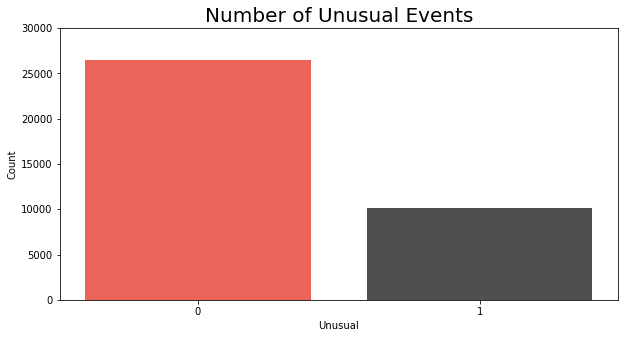

In [32]:
def plot_hist(data):
    plt.figure(figsize=[10, 5])
    plt.title("Number of Unusual Events", size=20)
    plt.ylabel("Count")
    plt.xlabel("Unusual")
    plt.ylim([0,30000])
    plt.bar([0,1], [data.Unusual.value_counts()[0], data.Unusual.value_counts()[1]], alpha=0.7, color=["#E32212", "#040404"])
    plt.xticks([0,1])
    plt.show()
plot_hist(df)

<span style="font-size:15px;"> Taking a deeper look at the target variable distribution is possible to see how much is unbalanced. </span>

## 3 - Data Quality Check 

<span style="font-size:15px; line-height:1.5em"> A comprehensive data quality assessment is always a recommended step in the data pipeline. The quality check we ran here does not highlight anything relevant other than the previously shown imbalance issue, so we can proceed with added confidence on every other dimensions of the data. </span>

In [8]:
# Create a DataQuality object from the main class that holds all quality modules
dq = DataQuality(df=df.copy())

# Run the tests and outputs a summary of the quality tests
results = dq.evaluate()

Warnings:
	TOTAL: 2 warning(s)
	Priority 2: 2 warning(s)


Priority 2 - usage allowed, limited human intelligibility:
	* [DUPLICATES - EXACT DUPLICATES] Found 219 instances with exact duplicate feature values.
	* [DATA RELATIONS - HIGH COLLINEARITY - NUMERICAL] Found 4 numerical variables with high Variance Inflation Factor (VIF>5.0). The variables listed in results are highly collinear with other variables in the dataset. These will make model explainability harder and potentially give way to issues like overfitting.Depending on your end goal you might want to remove the highest VIF variables.



## 4 - Preprocessing 

<span style="font-size:15px;"> Apply basic pre-processing techniques to prepare data for synthesization. Further processing is done inside of the Synthesizer. </span>

In [8]:
# Do the little preprocessing
df.drop_duplicates(inplace=True)
df.drop(['meanUE_DL', 'maxUE_DL', 'maxUE_UL'], axis=1, inplace=True)

## 5 - Classification on Original Data

<span style="font-size:15px;"> Train a classifier on the original data to detect the anomaly class (Unusual), then evaluate results. F1 score, Accuracy, recall and precision are used to assess the model's performance.  </span>

### 5.1 - Split Data

In [9]:
# Split the data into train and test
x_train, x_test = train_test_split(df, random_state=6)

### 5.2 - Train Classifier

In [10]:
orig_tree_clf = DecisionTreeClassifier(random_state=4)

orig_tree_clf.fit(x_train.drop('Unusual', axis=1), x_train['Unusual'])

DecisionTreeClassifier(random_state=4)

### 5.3 - Predict Class 

Scores: 
 Accuracy: 0.93 
 F1: 0.88 
 Precision: 0.87 
 Recall: 0.88 
 
 


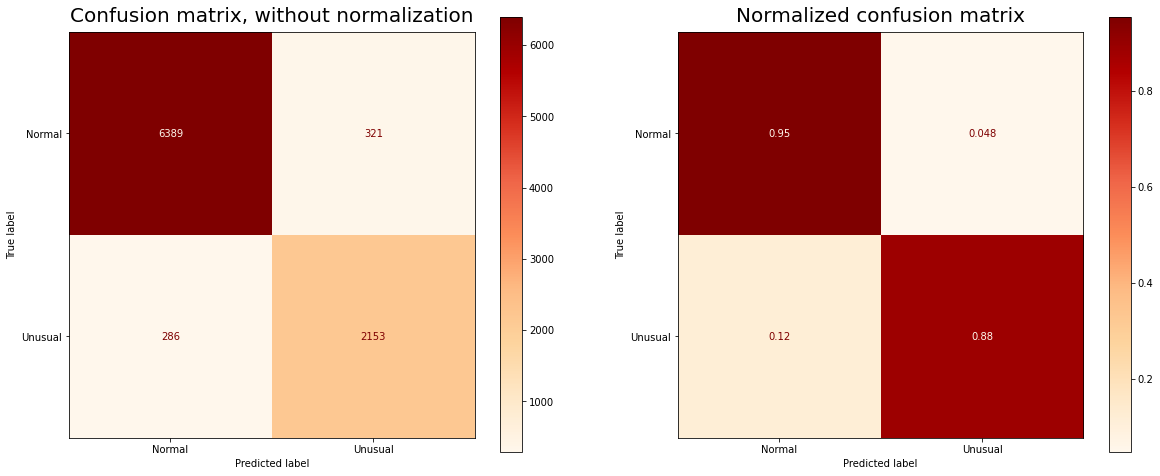

In [22]:
preds = orig_tree_clf.predict(x_test.drop('Unusual', axis=1))

def print_confusion_matrix(model, X_test, y_test):
    """ Plot normalized and non-normalized confusion matrices """
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

    fig, axes = plt.subplots(1,2,figsize=(20,8))
    for (title, normalize), ax in zip(titles_options, axes):

        disp = plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=["Normal", "Unusual"],
                                     cmap=plt.cm.OrRd,
                                     normalize=normalize,
                                     ax=ax)

        ax.set_title(title, fontsize=20, pad=10)

print_confusion_matrix(orig_tree_clf, x_test.drop('Unusual', axis=1), x_test['Unusual'].values)

acc = accuracy_score(x_test['Unusual'].values, preds)
f1 = f1_score(x_test['Unusual'].values, preds)
precision = precision_score(x_test['Unusual'].values, preds)
recall = recall_score(x_test['Unusual'].values, preds)

print('\033[1mScores:\033[0m \n Accuracy: {acc:.2f} \n F1: {f1:.2f} \n Precision: {precision:.2f} \n Recall: {recall:.2f} \n \n '.format(acc=acc, f1=f1, precision=precision, recall=recall))

## 6 - Synthesization  

<span style="font-size:15px;"> Upsample the existing data using the YData's Regular Synthesizer.  </span>

### 6.1 - Train Synthesizer 

In [17]:
from ydata.dataset import Dataset
# Initialize and Load an already trained Synthesizer.
network_synth = RegularSynthesizer(filter_outliers=False)
network_synth = network_synth.load('trained_model_unb.pkl')
#network_synth.fit(Dataset(df.query("Unusual == 1")))
#network_synth.save('trained_model_unb.pkl')

### 6.2 - Sample

<span style="font-size:15px;"> Sample data from the trained synthesizer and flag it for easier recognition.   </span>

In [18]:
# Create the samples and flag them.
synth_sample = network_synth.sample(16374).to_pandas()

# Flag the created samples and assign columns
synth_sample.index = repeat(999999, len(synth_sample))
synth_sample.columns = df.columns

INFO: 2022-03-31 10:15:43,408 [SYNTHESIZER] - Start generating model samples.


### 6.3 - Concatenate Data

<span style="font-size:15px;">Concatenate sampled data and original dataset.</span> 

In [19]:
data_augmented = concat([df, synth_sample])

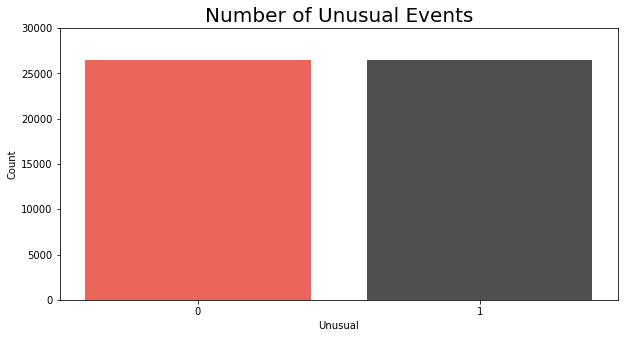

In [33]:
plot_hist(data_augmented)

<span style="font-size:15px;"> After the synthesization of data the target variable is no longer unbalanced.</span>

## 7 - Classification on Augmented Data

<span style="font-size:15px;"> Train a new classifier on the augumented data to detect the anomaly class (Unusual) and evaluate results.</span>

### 7.1 - Split Data 

In [25]:
# Take out the test data from the augmented data.
x_train_augmented = data_augmented.drop(x_test.index)

### 7.2 - Train Classifier

<span style="font-size:15px;"> Train the classifier on augmented data  </span>

In [26]:
# Create the DecisionTreeClassifier. One for the normal data and another for the augmented data.
aug_tree_clf = DecisionTreeClassifier(random_state=4)

# Fit the model and predict
aug_tree_clf.fit(x_train_augmented.drop('Unusual', axis=1), x_train_augmented['Unusual'])

DecisionTreeClassifier(random_state=4)

### 7.3 - Predict Class

Scores: 
 Accuracy: 0.94 
 F1: 0.89 
 Precision:       0.84 
 Recall: 0.95 
 
 


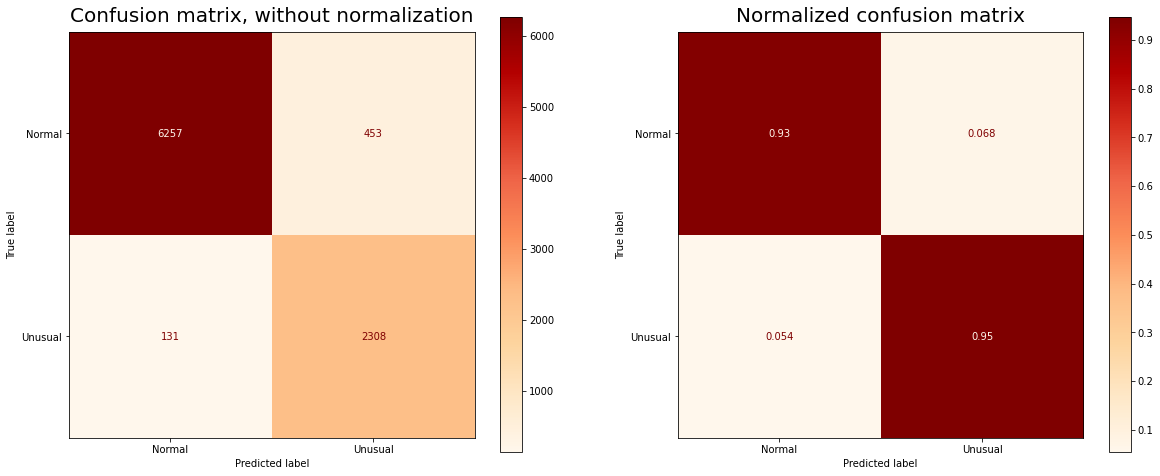

In [27]:
aug_preds = aug_tree_clf.predict(x_test.drop('Unusual', axis=1))
aug_acc = accuracy_score(x_test['Unusual'].values, aug_preds)
aug_f1 = f1_score(x_test['Unusual'].values, aug_preds)
aug_precision = precision_score(x_test['Unusual'].values, aug_preds)
aug_recall = recall_score(x_test['Unusual'].values, aug_preds)


print_confusion_matrix(aug_tree_clf, x_test.drop('Unusual', axis=1), x_test['Unusual'].values)
print('\033[1mScores:\033[0m \n Accuracy: {acc:.2f} \n F1: {f1:.2f} \n Precision: \
      {precision:.2f} \n Recall: {recall:.2f} \n \n '.format(acc=aug_acc, f1=aug_f1, precision=aug_precision, recall=aug_recall))

## 8 - Compare Results 

<span style="font-size:15px;"> Visualize the effect on the metrics caused by augmentation.  </span>

In [28]:
DataFrame({'F1_SCORE': [f1, aug_f1],'ACCURACY':[acc, aug_acc], 'RECALL': [recall, aug_recall], 'PRECISION': [precision, aug_precision]},
           index=['Original', 'Augmented'])

F1_SCORE  ACCURACY    RECALL  PRECISION
Original   0.876450  0.933654  0.882739   0.870251
Augmented  0.887692  0.936168  0.946289   0.835929

 <span style="font-size:15px;"> Althought we see a decrease in the precision score, an even greater increment is observed for the recall. Although the model trained with augmented data identifies with less precision the unusual events, it recognizes them in greater number leading to less unexpected unusual events. It can be seen from both f1 score and accuracy that have improved. So, as we can see from the metrics, the synthesization of the minority class brought an improvement to the discovery of anomalies that would lead to a better management of the network resources. </span>